In [57]:
import pandas as pd
import numpy as np
import yfinance as yf
import cvxpy as cp


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import datetime, timedelta

In [58]:
# Current date
end_date = datetime.now()

# Start date set to 15 years before the end date
start_date = end_date - timedelta(days=365*15)  # Approximating 365 days per year

# Defining portfolio components 
portfolio_items = {'BIST100': 'XU100.IS', 'Gold': 'GC=F', 'Silver': 'SI=F', 'USDTRY': 'USDTRY=X'}

In [59]:
def get_historical_data(portfolio_item: str, start_date: datetime, end_date: datetime):
    """
    Fetches historical market data from Yahoo Finance.
    """
    data = yf.download(portfolio_item, start=start_date, end=end_date)
    return data['Adj Close']

In [60]:
def calculate_annualized_returns(data):
    """
    Calculates annualized logarithmic returns from daily prices.
    """
    daily_returns = np.log(data / data.shift(1))
    annualized_returns = daily_returns.mean() * 252  # 252 trading days in a year
    return annualized_returns

In [61]:
def calculate_annualized_log_returns(dataframe, value_col):
    """
    Used for house price index and interest rate instruments
    Calculate the annualized logarithmic returns from a time series data.
    Args:
    dataframe (pd.DataFrame): DataFrame containing the data.
    date_col (str): Column name for dates.
    value_col (str): Column name for values (e.g., HPI or asset prices).
    optional_date_format (bool): Variable for format warnings.
    
    Returns:
    float: Annualized logarithmic return.
    """
    # Convert the value column to float to avoid type issues
    dataframe[value_col] = pd.to_numeric(dataframe[value_col], errors='coerce')

    # Drop rows with NaN values that might disrupt calculations
    dataframe.dropna(subset=[value_col], inplace=True)

    # Calculate logarithmic returns
    dataframe['log_returns'] = np.log(dataframe[value_col] / dataframe[value_col].shift(1))

    # Calculate annualized return (assuming the data is monthly, multiply by 12)
    annualized_return = dataframe['log_returns'].mean() * 12
    return annualized_return

In [62]:
def load_and_prepare_interest_data(dataset: pd.DataFrame):
    """
    Load and prepare interest data from a transposed Excel file.
    Args:
    filepath (str): Path to the Excel file.
    
    Returns:
    pd.DataFrame: Prepared DataFrame with 'Date' as a column.
    """
    # Load data, transpose and reset index to make the index a column
    df = dataset.copy().T
    df.reset_index(inplace=True)
    df.columns = df.iloc[0]  # Set the first row as column header
    df = df[1:]  # Remove the first row after setting headers
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)  # Rename the date column
    # df.set_index('Date', inplace=True)
    return df

In [63]:
# Fetch data
prices = {asset: get_historical_data(item, start_date, end_date) for asset, item in portfolio_items.items()}
# Load House Price Index
hpi_df = pd.read_excel('../data/konut-fiyat-endeks.xlsx')
# Convert date column to datetime and ensure data is sorted
hpi_df['Tarih'] = pd.to_datetime(hpi_df['Tarih'])
hpi_df.sort_values(by='Tarih', inplace=True)
# Load Interest Rates
interest_df = pd.read_excel('../data/tcmb-faiz.xlsx')
# Preprocess Interest Rates
interest_df = load_and_prepare_interest_data(interest_df)
# Convert date column to datetime and ensure data is sorted
interest_df['Date'] = pd.to_datetime(interest_df['Date'], format= '%Y-%m')
interest_df.sort_values(by='Date', inplace=True)
#
annualized_interest_return = calculate_annualized_log_returns(interest_df, '1 Yıla Kadar Vadeli (TL)(%)')
#
annualized_hpi_return = calculate_annualized_log_returns(hpi_df, 'TP HKFE01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [64]:
prices['Gold'] = prices['Gold'] * prices['USDTRY']
prices['Silver'] = prices['Silver'] * prices['USDTRY']

# The BIST 100 index underwent a significant recalibration on July 27, 2020. 
# This recalibration included updating how the index values were calculated 
# and possibly adjusting for market changes or sectoral shifts within the index. 
# e.g. 2009-05-04    32170.699219 / 2024-04-30    10099.299805
# Define the recalibration date and the adjustment factor
recalibration_date = pd.Timestamp('2020-07-27')
adjustment_factor = 100  # Multiplying factor before the recalibration date
# Apply the adjustment factor to all dates before the recalibration
prices['BIST100'].loc[prices['BIST100'].index < recalibration_date] /= adjustment_factor
# Therefore, it will be better to make USD-based calculations
# prices['BIST100_USD'] = prices['BIST100'] / prices['USDTRY']
# 
# bist100_tl = prices.pop('BIST100')

In [65]:
# Calculate annualized returns for each asset
returns = {asset: calculate_annualized_returns(data) for asset, data in prices.items()}
returns['HPI'] = annualized_hpi_return
returns['Interest'] = annualized_interest_return
# Output the results
for asset, return_value in returns.items():
    print(f"Annualized return for {asset}: {return_value:.4f}")

Annualized return for BIST100: 0.2322
Annualized return for Gold: 0.2708
Annualized return for Silver: 0.2499
Annualized return for USDTRY: 0.1953
Annualized return for HPI: 0.2536
Annualized return for Interest: 0.1244


In [66]:
def solve(ri_values: list[float]):
    # Define the decision variables for asset allocations
    x = cp.Variable(len(ri_values))
    
    # Define binary variables to handle the presence of investments
    y = cp.Variable(len(ri_values), boolean=True)  # Using boolean constraints for binary nature
    
    # Define the constraints
    constraints = [
        cp.sum(x) == 1,  # Total investment equals 100% of the budget
        x >= 0.15 * y,   # Link investment amounts to binary variables
        x <= 0.40 * y,   # Maximum investment constraint also linked to binary variables
        cp.sum(y) >= 3   # At least three different assets must be included
    ]

    # Define the objective function to maximize returns
    objective = cp.Maximize(ri_values @ x)

    # Define the problem and solve
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    # Output the optimal asset allocations
    if prob.status not in ["infeasible", "unbounded"]:
        # If the problem is feasible and bounded
        print("Optimal asset allocations:", x.value)
        print("Investment decisions (binary):", y.value)
        print("Maximum Expected Return:", result)
    else:
        # If the problem is infeasible or unbounded
        print("Problem status:", prob.status)
    return result
        

In [67]:
assets = returns.keys()
print(assets)
annual_return_rate = solve(list(returns.values()))

dict_keys(['BIST100', 'Gold', 'Silver', 'USDTRY', 'HPI', 'Interest'])
Optimal asset allocations: [-0.   0.4  0.2  0.   0.4  0. ]
Investment decisions (binary): [0. 1. 1. 0. 1. 0.]
Maximum Expected Return: 0.2597099367171441


In [68]:
initial_investment = 100
years = 15
total_return = initial_investment * (1 + annual_return_rate)**years
print(f"Total return: {total_return}")
# Calculate the cumulative investment value over time
years_array = np.arange(0, years + 1, 1)  # Array from 0 to 15
nominal_cumulative_values = initial_investment * (1 + annual_return_rate) ** years_array

# Calculate cumulative inflation
annual_inflation_df = pd.read_csv('../data/tufe.csv', delimiter=';')
annual_inflation_df['Tarih'] = pd.to_datetime(annual_inflation_df['Tarih'], format='%m-%Y')

# Sort the DataFrame
annual_inflation_df.sort_values(by=['Tarih'], inplace=True)
# Filter the DataFrame to the date range
annual_inflation_df = annual_inflation_df[(annual_inflation_df['Tarih'] > start_date) & (annual_inflation_df['Tarih'] < end_date)]

total_months = len(annual_inflation_df)
annual_inflation_data = []
months_this_year = 0
previous_index = 0
for i in range(0, total_months, 12):
    months_this_year = min(12, total_months - i)
    annual_inflation_data.append(annual_inflation_df.iloc[i]['TÜFE (Yıllık % Değişim)'])
    previous_index = i

if months_this_year != 12:
    annual_inflation_data.append(sum([annual_inflation_df.iloc[previous_index + i]['TÜFE (Aylık % Değişim)'] for i in range(months_this_year)]))

# Convert cumulative inflation percentage to factor
cumulative_inflation_factor = (1 + np.array(annual_inflation_data) / 100)

# Calculate real cumulative values
real_cumulative_values = nominal_cumulative_values / cumulative_inflation_factor

Total return: 3191.966516150669


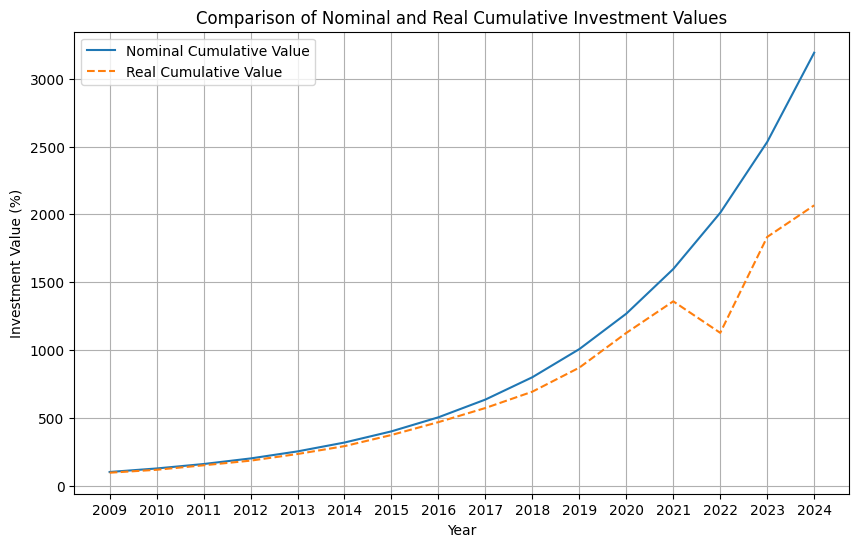

In [69]:
adjusted_start_year = start_date.replace(month=1, day=1)
years_array = pd.date_range(start=adjusted_start_year, end=end_date, freq='YS').year  # 'YS' stands for year start frequency

# If you need it as a list of strings (e.g., for labels):
years_list = [str(year) for year in years_array]
plt.figure(figsize=(10, 6))
plt.plot(years_list, nominal_cumulative_values, label='Nominal Cumulative Value')
plt.plot(years_list, real_cumulative_values, label='Real Cumulative Value', linestyle='--')
plt.title('Comparison of Nominal and Real Cumulative Investment Values')
plt.xlabel('Year')
plt.ylabel('Investment Value (%)')
plt.legend()
plt.grid(True)
plt.show()

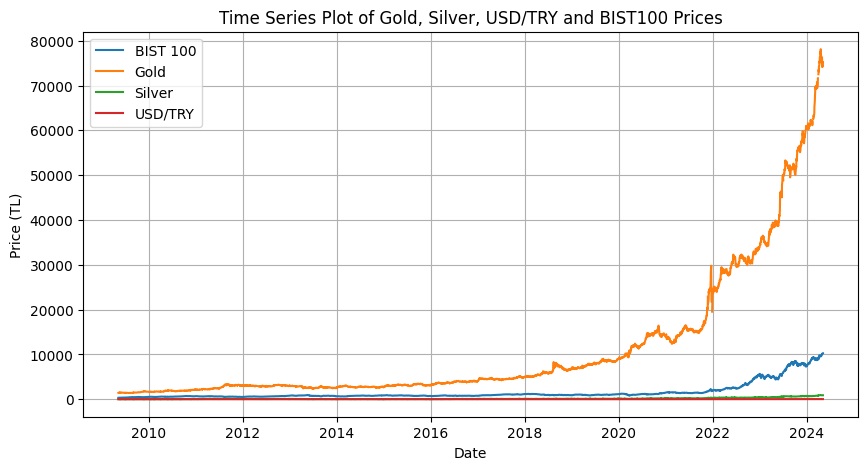

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(prices['BIST100'], label='BIST 100')
plt.plot(prices['Gold'], label='Gold')
plt.plot(prices['Silver'], label='Silver')
plt.plot(prices['USDTRY'], label='USD/TRY')
plt.title('Time Series Plot of Gold, Silver, USD/TRY and BIST100 Prices')
plt.xlabel('Date')
plt.ylabel('Price (TL)')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# Normalize the log returns using manual scaling
def normalize_data(series):
    return (series - series.mean()) / series.std()

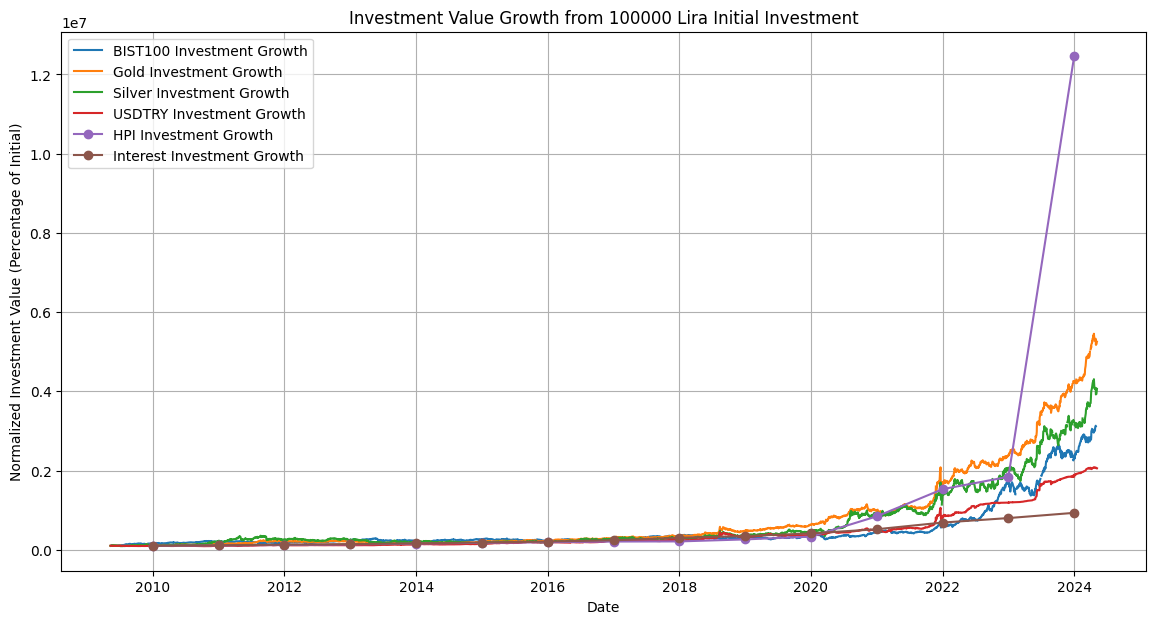

In [72]:
normalized_data = {}
initial_investment = 100000

for asset, series in prices.items():
    normalized_data[asset] = (series / series.iloc[0]) * initial_investment


# List to hold the results, starting with the initial investment
hpi_investment_values = [initial_investment]
# Track the previous investment value starting from initial investment
previous_hpi_value = initial_investment

# Calculate the yearly change in HPI
total_months = len(hpi_df)
for i in range(0, total_months, 12):
    # Determine how many months to calculate for this period
    months_this_year = min(12, total_months - i)
    # Calculate the HPI growth ratio from start to end of the year
    if i + months_this_year < total_months:
        start_hpi = hpi_df['TP HKFE01'].iloc[i]
        end_hpi = hpi_df['TP HKFE01'].iloc[i + months_this_year - 1]
        hpi_growth = (end_hpi / start_hpi)
    else:
        # In case the last iteration doesn't exactly align with full months
        hpi_growth = (hpi_df['TP HKFE01'].iloc[-1] / hpi_df['TP HKFE01'].iloc[i])

    # Update the investment value according to HPI growth
    new_hpi_value = previous_hpi_value * hpi_growth
    previous_hpi_value = new_hpi_value
    hpi_investment_values.append(new_hpi_value)

# If the last period doesn't align with a full year boundary, handle it here
remaining_months = total_months % 12
if remaining_months > 0:
    # Calculate the last partial year's growth if it hasn't been calculated
    last_rate = hpi_df['TP HKFE01'].iloc[total_months - remaining_months] / 100
    final_value = previous_hpi_value * (1 + last_rate * (remaining_months / 12))
    hpi_investment_values.append(final_value)

# Create a pandas Series from the list for easy plotting, aligning dates
hpi_investment_series = pd.Series(hpi_investment_values, index=pd.date_range(start=start_date, periods=len(hpi_investment_values), freq='YE'))

normalized_data['HPI'] = hpi_investment_series

interest_column = '1 Yıla Kadar Vadeli (TL)(%)'
interest_df.set_index('Date', inplace=True)

# Annual compounding from 100 lira at each year's interest rate
normalized_data['Interest'] = [initial_investment]
# List to hold the results
investment_values = [initial_investment]
# Track the previous investment value starting from initial investment
previous_value = initial_investment
# Calculate the compounded interest, adjusting for a partial last year if necessary
total_months = len(interest_df)
for i in range(0, total_months, 12):
    # Determine how many months to calculate for this period
    months_this_year = min(12, total_months - i)
    # Annual rate from the column
    annual_rate = interest_df['1 Yıla Kadar Vadeli (TL)(%)'].iloc[i] / 100

    # Adjust for partial year if this loop iteration is the last
    if months_this_year < 12:
        # Partial year, apply a proportional rate
        new_value = previous_value * (1 + annual_rate * (months_this_year / 12))
    else:
        # Full year, apply the full annual rate
        new_value = previous_value * (1 + annual_rate)

    # Update the previous value for the next iteration
    previous_value = new_value
    # Append the updated investment value to the list after each full or partial year
    investment_values.append(new_value)

# If the last period doesn't align with a full year boundary, handle it here
remaining_months = total_months % 12
if remaining_months > 0:
    # Calculate the last partial year's growth if it hasn't been calculated
    last_rate = interest_df['1 Yıla Kadar Vadeli (TL)(%)'].iloc[total_months - remaining_months] / 100
    final_value = previous_value * (1 + last_rate * (remaining_months / 12))
    investment_values.append(final_value)

# Convert to Series for plotting or further analysis
investment_series = pd.Series(investment_values, index=pd.date_range(start=start_date, periods=len(investment_values), freq='YE'))

normalized_data['Interest'] = investment_series
# Create DataFrame from normalized data
investment_df = pd.DataFrame(normalized_data)
# Plotting the normalized investment values
plt.figure(figsize=(14, 7))
for asset in investment_df.columns:
    if asset == 'Interest':
        plt.plot(investment_series, marker='o', linestyle='-', label=f'{asset} Investment Growth')
    elif asset == 'HPI':
        plt.plot(hpi_investment_series, marker='o', linestyle='-', label=f'{asset} Investment Growth')
    else:
        plt.plot(investment_df.index, investment_df[asset], label=f'{asset} Investment Growth')

plt.title('Investment Value Growth from 100000 Lira Initial Investment')
plt.xlabel('Date')
plt.ylabel('Normalized Investment Value (Percentage of Initial)')
plt.legend()
plt.grid(True)
plt.show()
